In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set(font_scale=1.5)

**************************************************

Parcel workplace param sweep cumulative interventions

**************************************************

Get variables

In [4]:
df = pd.read_pickle('all_interventions_parcel.pkl',compression='bz2')
df['NRecovered'] = df['FracRecovered']*df['NStaff']
print(df.columns)

Index(['Group', 'NStaff', 'Iteration', 'FracRecovered', 'FomiteInfectionFrac',
       'CohortInfectionFrac', 'RandContactInfectionFrac', 'PairInfectionFrac',
       'RoomInfectionFrac', 'ExtIntroFrac', 'CustIntroFrac', 'CarShareInfFrac',
       'HouseShareInfFrac', 'CustomersInfected', 'IsolatorsFrac',
       'SympIsolatorsFrac', 'FPIsolatorsFrac', 'TPSympIsolatorsFrac',
       'TPAsympIsolatorsFrac', 'is_testing', 'Dtime', 'protocol', 'tperiod',
       'specificity', 'Ltime', 'new_comply_prob', 'tD', 'SimType',
       'BreakContactProb', 'TeamTimes', 'CarShareIsolation', 'phi',
       'TeamDistances', 'PkgHlife', 'InfInit', 'HouseShareFactor',
       'CarShareFactor', 'Psusc', 'delay', 'Pisol', 'NDteams', 'is_cohorts',
       'HouseShareIsolation', 'p_contact', 'CohortIsolation', 'test_pause',
       'Office_WFH', 'CohortChangeRate', 'p_fomite_trans', 'NOteams',
       'TeamsOutside', 'NLteams', 'NRecovered'],
      dtype='object')


In [5]:
dfall = df[df["Group"]=='All']
dfall['outbreak'] = (dfall['NRecovered'] > 4)
dfall['Ninfected'] = (dfall.loc[:,'FracRecovered']*dfall.loc[:,'NStaff'])
dfall['Introductions'] = (dfall["ExtIntroFrac"] + dfall["CustIntroFrac"])*dfall["NStaff"]
dfall['Secondary'] = dfall['Ninfected'] - dfall['Introductions']

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [6]:
Nrows = len(df)
Conditions = np.array(["+Office WFH","+ Distancing","+ Testing","+ House Share Isolation",\
                       "+ Car Share Isolation","+ Cohort Isolation","+ Enforced testing"])
print(Nrows, len(Conditions))
BoolCond = np.zeros((Nrows,len(Conditions)),dtype=bool)
nda = np.arange(Nrows) + 2
nda[-1] = 1
nda[-2] = 0
npa = np.arange(Nrows) + 1
npa[-1] = 0
Group = df["Group"].to_numpy()
NStaff = df["NStaff"].to_numpy()
BoolCond[:,0] = df["Office_WFH"]
naa = np.arange(Nrows) - 2
Tdist = df["TeamDistances"].to_numpy()
BoolCond[:,1] = (Tdist > 1.5) + \
                ((Group == "All") & (Tdist[naa] > 1.5))
BoolCond[:,2] = df["is_testing"]
BoolCond[:,3] = df["HouseShareIsolation"]
BoolCond[:,4] = df["CarShareIsolation"]
BoolCond[:,5] = df["CohortIsolation"]
BoolCond[:,6] = (df["new_comply_prob"] > 0.5)
NCond = np.sum(BoolCond,0)
CondOrder = np.flip(np.argsort(NCond))
print(NCond)
print(CondOrder)
print(np.unique(NStaff))
Conditions = Conditions[CondOrder]

640000 7
[400000 560000 320000 480000 160000  80000 240000]
[1 3 0 2 6 4 5]
[15 25 50 90]


/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

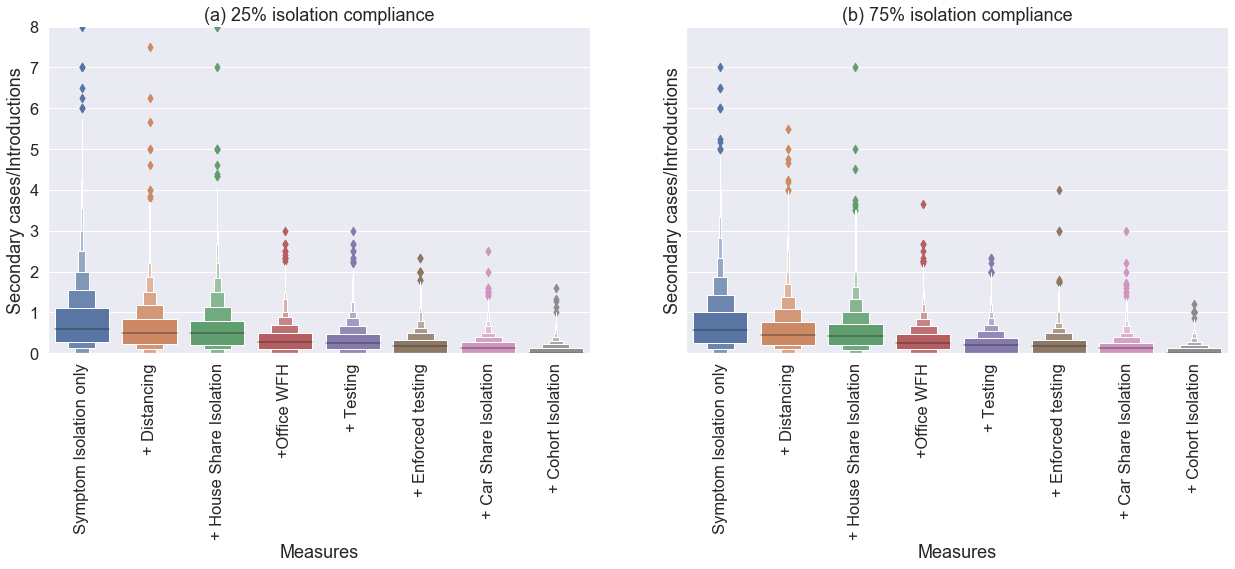

In [10]:
dfall['SecondaryFrac'] = dfall['Secondary']/dfall['Introductions']
dfall['Conditions'] = np.zeros(len(dfall),dtype=np.object)
Intros = dfall["Introductions"].to_numpy()
for i in np.arange(len(Conditions)+1):
    rowcond = np.zeros(len(Conditions),dtype = np.bool)
    for j in np.arange(i):
        rowcond[CondOrder[j]] = True
    rowbool = np.all(BoolCond == rowcond,1)
    rowboolall = rowbool[(Group=="All")]
    
    if i == 0:
        lab = "Symptom Isolation only"
    else:
        lab = Conditions[i-1]
    dfall['Conditions'][rowboolall] = lab
    

dfallintros = dfall[Intros>0]
sp = sns.catplot(x="Conditions", y="SecondaryFrac", data=dfallintros, col='Pisol', kind='boxen', \
                 height=6, aspect=1.5)
sp.set(ylim=(0,8),xlabel="Measures",ylabel="Secondary cases/Introductions")
sp.set_xticklabels(rotation=90)
ax = sp.axes.flatten()
ax[0].set_title('(a) 25% isolation compliance')
ax[1].set_title('(b) 75% isolation compliance')
sp.savefig('Secondary_infs_interventions.png')

Count isolations

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


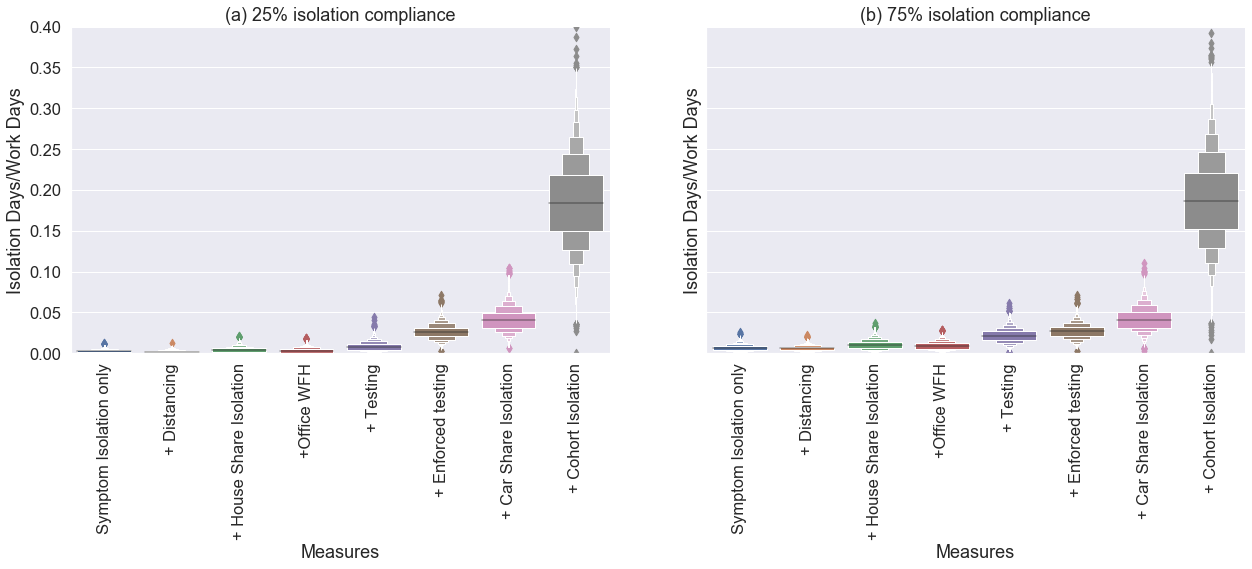

In [12]:
dfallintros = dfall[Intros>0]
dfallintros["IsolationDaysFrac"] = dfallintros["IsolatorsFrac"]*10/92

sp = sns.catplot(x="Conditions", y="IsolationDaysFrac", data=dfallintros, col='Pisol', kind='boxen', \
                 height=6, aspect=1.5)
sp.set(ylim=(0,0.4), xlabel="Measures",ylabel="Isolation Days/Work Days",\
       title=['','(b)'])
sp.set_xticklabels(rotation=90)
ax = sp.axes.flatten()
ax[0].set_title('(a) 25% isolation compliance')
ax[1].set_title('(b) 75% isolation compliance')

sp.savefig('Isol_days_interventions.png')

In [7]:
print(dfall.columns)

Index(['Group', 'NStaff', 'Iteration', 'FracRecovered', 'FomiteInfectionFrac',
       'CohortInfectionFrac', 'RandContactInfectionFrac', 'PairInfectionFrac',
       'RoomInfectionFrac', 'ExtIntroFrac', 'CustIntroFrac', 'CarShareInfFrac',
       'HouseShareInfFrac', 'CustomersInfected', 'IsolatorsFrac',
       'SympIsolatorsFrac', 'FPIsolatorsFrac', 'TPSympIsolatorsFrac',
       'TPAsympIsolatorsFrac', 'is_testing', 'protocol', 'tperiod',
       'specificity', 'new_comply_prob', 'tD', 'SimType', 'BreakContactProb',
       'TeamTimes', 'CarShareIsolation', 'phi', 'TeamDistances', 'InfInit',
       'HouseShareFactor', 'CarShareFactor', 'Psusc', 'delay', 'Pisol',
       'NDteams', 'is_cohorts', 'HouseShareIsolation', 'p_contact',
       'CohortIsolation', 'test_pause', 'Office_WFH', 'NOteams',
       'TeamsOutside', 'NLteams', 'NRecovered', 'outbreak', 'Ninfected',
       'Introductions', 'Secondary', 'SecondaryFrac', 'Conditions'],
      dtype='object')


In [24]:
print(np.unique(dfall["NStaff"]))

[58 68]


In [25]:
92*58

5336